# Chapter 3 - Segmentation of cell images and detection of cell positions

This notebook is a more detailed description of much of the code I used in Chapter 3 of my thesis.

This follows:
    - Different approaches to segment the images
    - Implementing a custom convolution kernel to augment the images
    - Establishing a bounary around segmented objects
    - Establishing countours around objects
    - Extracting the central position of contours

I've used an example partion of the Exp2_GFP.avi time-lapsed-miscroscopy movie as an example.

In [92]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### This is our 200x200 pixel image partion. Cells are barely visible by eye, but segmentation methods can binarize the image to help distuinguish between cells and the background 

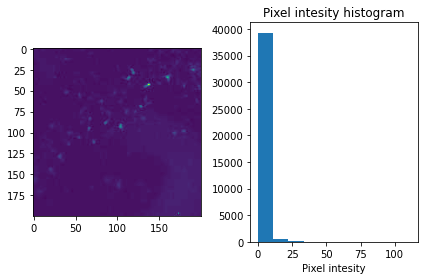

In [93]:
image_file = cv2.imread('Images/GFP/Exp2_GFP.png')
image_file = cv2.cvtColor(image_file, cv2.COLOR_RGB2GRAY)

fig, ax = plt.subplots(1,2)


ax[0].imshow(image_file)
ax[1].hist(image_file.flatten())
ax[1].set_xlabel('Pixel intesity')
ax[1].set_title('Pixel intesity histogram')
plt.tight_layout()

### OpenCV has a collection of "ready-baked" segmentation methods to binarize the image. 
This includes: 
    - Otsu's binarization
    - K-means clustering
    - Adaptive Gaussian thresholding
    - Adaptive mean thresholding
    - Laplacian filtering


#### Otsu:

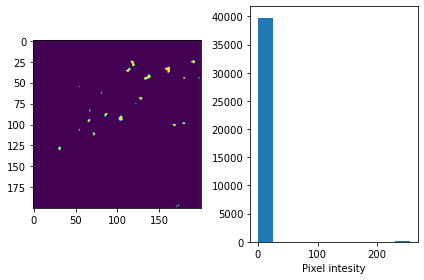

In [94]:
_, otsu = cv2.threshold(image_file, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)





fig, ax = plt.subplots(1,2)

ax[0].imshow(otsu)
ax[1].hist(otsu.flatten())
ax[1].set_xlabel('Pixel intesity')





plt.tight_layout()


#### K-means clustering:

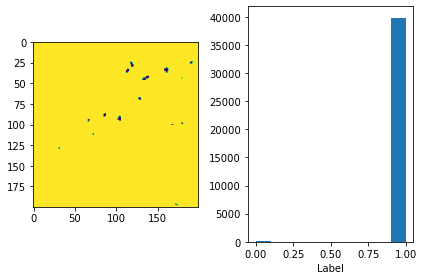

In [95]:
kmeans = image_file.reshape((-1))
kmeans = np.float32(kmeans)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, label, center = cv2.kmeans(kmeans, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
kmeans = label.reshape((image_file.shape))

fig, ax = plt.subplots(1,2)


ax[0].imshow(kmeans-1)
ax[1].hist(kmeans.flatten())
ax[1].set_xlabel('Label')


plt.tight_layout()

#### Adaptive gaussian threshold:

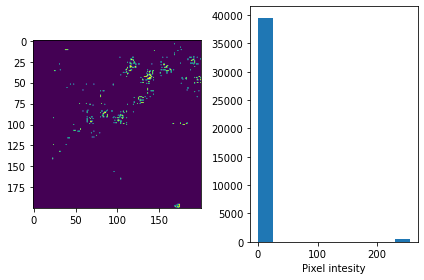

In [96]:
adap_g = cv2.adaptiveThreshold(image_file,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,3,2)


fig, ax = plt.subplots(1,2)


ax[0].imshow(adap_g)
ax[1].hist(adap_g.flatten())
ax[1].set_xlabel('Pixel intesity')


plt.tight_layout()

#### Adaptive mean threshold:

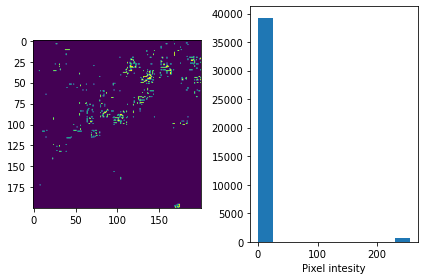

In [97]:
adap_m = cv2.adaptiveThreshold(image_file,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,3,2)

fig, ax = plt.subplots(1,2)


ax[0].imshow(adap_m)
ax[1].hist(adap_m.flatten())
ax[1].set_xlabel('Pixel intesity')


plt.tight_layout()

#### Laplacian filtering:

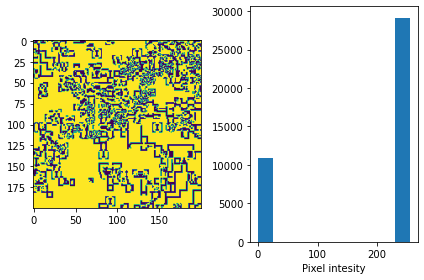

In [98]:
lalpacian = cv2.Laplacian(image_file, cv2.CV_16S, ksize=5)
lalpacian = cv2.bitwise_not(lalpacian)
lalpacian = np.uint8(lapcalian)
_, lalpacian = cv2.threshold(lalpacian, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


fig, ax = plt.subplots(1,2)


ax[0].imshow(lalpacian)
ax[1].hist(lalpacian.flatten())
ax[1].set_xlabel('Pixel intesity')


plt.tight_layout()

### Custom filter
#### We generated multiple Laplacian-inspired convolutional filters and found the most optimal to be a 9x9 kernel as shown:

In [99]:
def make_filter(mat):
    ksize, value = mat
    k1, k2, v_min, v_max = ksize, ksize, -1, value
    conv_filter = np.array([[v_min] * k1] * k2)
    (conv_filter[int((k2 / 2))][int((k1 / 2))]) = v_max

    return conv_filter

def apply_filter(im, mat):
    frame = im
    conv_filter = make_filter(mat)


    frame = cv2.filter2D(frame, -1, conv_filter)
    original_frame = frame.copy()
    _, frame = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    

    return frame, original_frame

make_filter([9, 61])

array([[-1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, 61, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1]])

#### I then segmented the images using the filter before applying Otsu's binarization

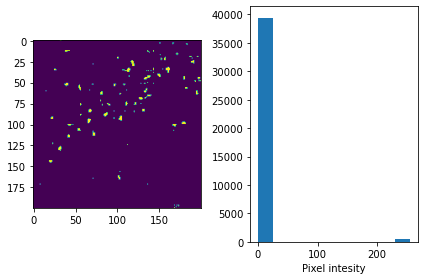

In [100]:
custom_filter = apply_filter(image_file, [9, 61])[0]
fig, ax = plt.subplots(1,2)


ax[0].imshow(custom_filter)
ax[1].hist(custom_filter.flatten())
ax[1].set_xlabel('Pixel intesity')


plt.tight_layout()

### To add extra boundary definition, I used a Watershed approach

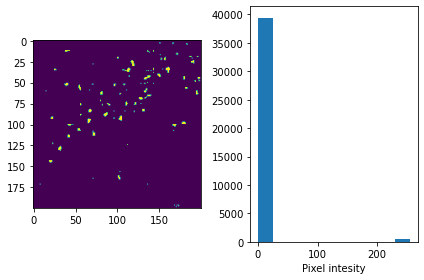

In [101]:
    def run_watershed(img):
        kernel = np.ones((3, 3), np.uint8)
        opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=0)

        sure_bg = cv2.dilate(img, kernel, iterations=2)

        dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
        ret, sure_fg = cv2.threshold(dist_transform, .1 * dist_transform.max(), 255, 0)

        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)

        ret, markers = cv2.connectedComponents(sure_fg)

        markers = markers + 1

        markers[unknown == 255] = 0
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        markers = cv2.watershed(img, markers)
        img[markers == -1] = [0, 0, 0]
        thresh = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        return thresh
    
custom_filter_watershed = run_watershed(custom_filter)

fig, ax = plt.subplots(1,2)

ax[0].imshow(custom_filter_watershed)
ax[1].hist(custom_filter_watershed.flatten())
ax[1].set_xlabel('Pixel intesity')


plt.tight_layout()

### I then used the OpenCV contour detection function and used moments to determine the centroid of the contours

In [102]:
def moments(cent):
    M = cv2.moments(cent)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0

    return (cX, cY)

def find_contours(img):
    frame = img

    contours, hier = cv2.findContours(frame, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    area = np.array([cv2.contourArea(i) for i in contours])
    centroids = np.array([moments(i) for i in contours])
    return centroids, contours, area

centroids, contours, areas = find_contours(custom_filter_watershed)

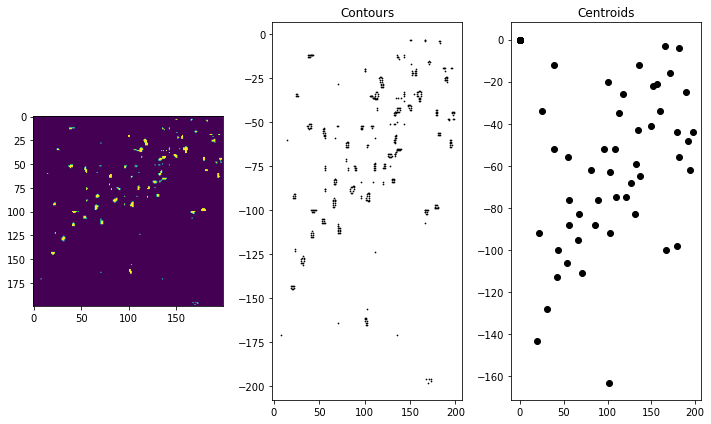

In [103]:
fig, ax = plt.subplots(1,3, figsize=[10, 6])
ax[0].imshow(custom_filter_watershed)
for i in contours:
    for j in i:
        
        ax[1].scatter(j[0][0], -j[0][1], c='k', s=0.5)
ax[1].set_title('Contours')

for i in centroids:
    ax[2].scatter(i[0], -i[1], c='k')
ax[2].set_title('Centroids')
plt.tight_layout()